 # <center>  Lecture 6 : MCMC </center>  
 
##  <center>  Instructor: Dr. Hu Chuan-Peng   </center>  


在上一节课中，通过简单的 Beta-Binomial 模型中，我们已经看到 PyMC 可以帮助我们得到后验分布。

且这个过程中使用了**MCMC算法** 从后验分布中进行抽样。

为什么 **MCMC算法** 可以得到后验分布的样本？🤔  

为了更深入理解这些方法，我们现在回到基础，从第一个MC(Monte Carlo)方法开始。😎  

## Monte Carlo, Markov Chain 和 Markov Chain Monte Carlo

### 什么是 Monte Carlo

- Monte Carlo 方法是一种通过**随机采样**模拟复杂现象的数值计算方法。

假设我们知道这个正方形的面积，想估算图中圆形的面积（但不使用圆的面积的公式），通过何种近似的方法可以怎么解决这一问题呢？

<center>  
    <table>  
            <tr>  
                <td><img src="https://cdn.kesci.com/upload/slozv1v2pv.png?imageView2/0/w/480/h/960" alt=""></td>  
                <td><img src="https://cdn.kesci.com/upload/slozv7t6h6.png?imageView2/0/w/480/h/960" alt=""></td>  
            </tr>  
            <tr>  
                <td></td>  
                <td></td>  
            </tr>  
    </table>  
</center>  

1. **随机投点**：我们在一个边长为 10 英寸 的正方形区域内随机放置 20 个点。
2. **计算圆内的点数比例**：统计这些点中有多少落在圆内，并计算这一比例。
3. **面积估算**：根据比例，乘以正方形的面积（100 平方英寸），即可得到近似的圆面积。

**Monte Carlo 的核心思想**：
  1. **随机抽样**：通过从某个已知的概率分布中随机抽样，估计该分布的期望或其他统计量。
  2. **近似逼近**：随着样本数量增加，抽样结果会逐渐逼近真实分布的统计特性。

#### Normal-Normal 模型的后验分布  

首先，是我们正态模型为例子（贝叶斯中，我们使用 Normal-Normal表示先验与似然都是Normal Dist）。  

假设我们知道一个正态分布的标准差为0.75的正态分布，但是其平均值$\mu$是未知的，我们想通过从这个正态分布中取一个数据来估计这个正态分布的平均值$\mu$的范围。

1. **似然模型**：假设我们从一个平均值为$\mu$，标准差为0.75的正态分布中获取了一个$Y=6.25$的数据：  
    $$  
    Y|\mu  \sim \ N(\mu, 0.75^2)  
    $$  

2. **先验模型**：假定这个正态分布的均值是可能是从如下正态分布中取值的：  
    $$  
    \mu  \sim \ N(0, 1^2)  
    $$  

    *可以简单理解成我们一开始对$\mu$的信念，为$\mu$在平均值为0，标准差为1的正态分布中波动*  

3. **后验分布**：那么在$Y=6.25$这个结果下，结合先验，更新后的$\mu$是怎样的？  

    $$\mu | (Y = 6.25) \sim \text{N}(?,?)$$  

**后验分布解析解：**  

在lec5中，我们知道Normal-Normal为共轭先验，则后验分布存在可进行直接的计算：

$$  
\mu|\vec{y} \sim N\left(\frac{\theta\sigma^2 + \bar{y}n\tau^2}{n\tau^2 + \sigma^2}, \frac{\tau^2\sigma^2}{n\tau^2 + \sigma^2}\right)  
$$  

其中：  
- $\bar{y}$ 是样本的均值（观测到的平均正确率），  
- $\sigma^2$ 是已知的正确率方差，  
- $\tau^2$ 是先验的方差。  

- **后验均值**：后验均值是先验均值 $\theta$ 和样本均值 $\bar{y}$ 的加权平均：  

  $$  
  \text{posterior mean} = \frac{0 \times 0.75^2 + 6.25 \times 1^2}{1^2 + 0.75^2} = \frac{6.25}{1.5625} = 4  
  $$  

- **后验方差**：后验方差受先验的方差 $\tau^2$ 和样本数据的方差 $\sigma^2$ 的共同影响：  

  $$  
  \text{posterior variance} = \frac{1^2 \times 0.75^2}{1^2 + 0.75^2} = \frac{0.5625}{1.5625} = 0.6^2 
  $$  
 
> 因此，我们得到更新后的$\mu$的分布为：
> $$\mu | (Y = 6.25) \sim \text{N}(4, 0.6^2)$$  


**后验分布模型 vs. 从后验分布采样**  

📍需要明确的一点：通过解析计算得到的后验分布模型与从基于后验分布的采样结果并不完全相同。 

在上述例子中，我们通过解析计算得到了后验分布的具体形式（模型）：
> $$\mu | (Y = 6.25) \sim \text{N}(4, 0.6^2)$$  

这并不意味着我们可以直接从表达式中获得参数的**样本**。为了生成这些样本，我们需要通过Monte Carlo过程采样。

简单地说：我们希望得到的样本的数量与每个样本在分布模型中的可能性之间是成比例的，某个值出现的概率越大，在采样中，它出现的次数应该越多。

反过来：如果我们能从某个分布中采到足够多的样本，那么我们也可以通过对这些样本的统计量进行计算，来估计这个分布本身的模型参数。

在现代的概率编辑语言中，我们很容易能够进行Monte Carlo采样。

比如，对于上述的正态分布 $N(4, 0.6^2)$，我们可以通过如下代码进行Monte Carlo采样并进行可视化：

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

x_range = np.linspace(2, 10, 1000)       # 设置 x 的范围为 [2,10] 
y_norm = norm.pdf(x_range, 6.25, 0.75)

# 对y_norm进行采样，得到1000个样本值
samples = np.random.normal(6.25, 0.75, 1000)

# 显示前 10 个样本值
first_10_samples = samples[:10]
print("前 10 个样本值：", first_10_samples)

前 10 个样本值： [7.82106053 5.84653561 5.51158156 6.38897953 7.6325137  5.08262722
 6.76971937 7.50396243 7.28796121 5.31063869]


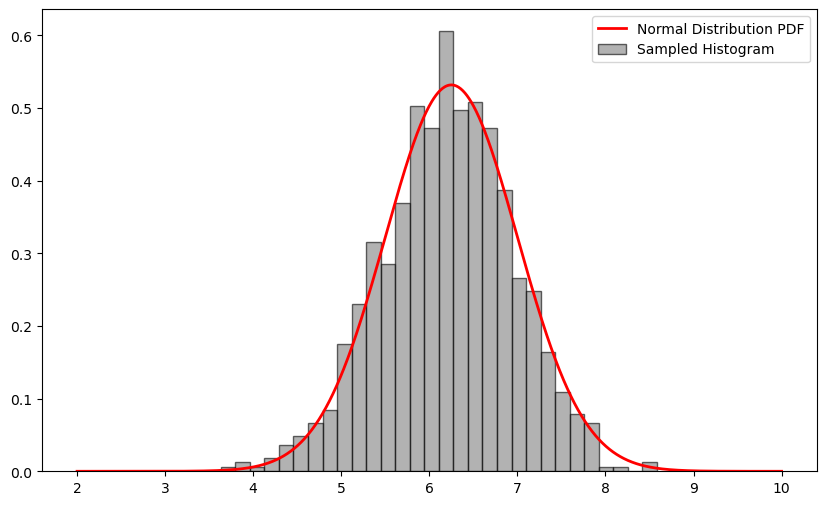

In [2]:
#  绘制图像
plt.figure(figsize=(10, 6))
plt.plot(x_range, norm.pdf(x_range, 6.25, 0.75), linewidth=2, color='r', label='Normal Distribution PDF')
count, bins, ignored = plt.hist(samples, bins=30, density=True, alpha=0.6, color='grey', edgecolor='black', label='Sampled Histogram')

plt.legend()
plt.show()

**未归一化的后验分布(unnormalized posterior pdf)**  

我们在上节课讲到，在现实的数据分布中，往往模型比较复杂，导致我们进行的计算变得复杂，尤其是分母部分的归一化因子，

❓为什么归一化因子比较难以计算？  


假如归一化因子（分母）比较难以计算，是不是可以不计算？

<center>  
    <table>  
            <tr>  
                <td><img src="https://cdn.kesci.com/upload/slozv1v2pv.png?imageView2/0/w/480/h/960" alt=""></td>  
                <td><img src="https://cdn.kesci.com/upload/slozv7t6h6.png?imageView2/0/w/480/h/960" alt=""></td>  
            </tr>  
            <tr>  
                <td></td>  
                <td></td>  
            </tr>  
    </table>  
</center>  

Q: 假如我们只知道上面随机点的信息，但不知道正方形的面积，我们如何估算圆的面积？
A: 使用足够多的点，计算圆内点的比例

对于贝叶斯推断来说，我们可能可以不用计算归一化因子，直接通过对后验分布的采样来近似得到后验分布。

$$f(\mu | y=6.25) \propto f(\mu)L(\mu|y=6.25).$$  

- 尽管未归一化的分布并不是真正的后验分布，但这二者的形状、集中趋势、变异性是一样的  
- 可以看到，真实的后验分布和未归一化后验分布，处理在 y 轴上的单位不一样，但他们的形状、集中趋势、变异性是一样的  
- 重要的是，两个分布中，$\mu$ 的结果主要集中在 2-6 之间  

因此，当进行采样时，我们可以使用**未归一化的后验分布** 的结果来替代计算真实的后验分布 $f(\mu)$  

![Image Name](https://cdn.kesci.com/upload/s2ty9jty8t.png?imageView2/0/w/960/h/960)  


那么新的问题是，如何在不计算复杂归一化常数的情况下，有效地生成样本？🤔


### Markov Chain Monte Carlo

Markov Chain（马尔可夫链）即可自然地解决了未归一化的后验分布的问题。

原因：
- 每次只关注当前的状态。
- 利用当前状态生成建议分布（proposed distribution）。
- 判断是否接受新的状态，构建一个链条来近似后验分布。

我们以一个心情变化的例子来深入理解 Markov Chain：

- 假如不同的情绪对应一种状态，也就是参数可能的取值。
- 那么，我们可以将不同的心情（如“冷静”、“悲伤”、“开心”）定义为 状态。这些状态中的每一个代表参数 $\theta_k$ 的不同取值：
  - 例如，冷静是 $\theta_1=0.5$; 悲伤是 $\theta_2=0.3$；开心是$\theta_3=0.7$； 以此类推.....。  
  - 这样，我们可以确定参数选择的范围 $\theta_{k} \sim [0,1]$，参数是离散变量，每一个值对应一种心情。  
  - 注意，我们用下标 k 来表示不同的心情以及对应的参数值。  

<table>  
    <tr>  
        <td><img src="https://cdn.kesci.com/upload/s2vta0gekr.png?imageView2/0/w/500/h/500" alt="图片1" width = 600></td>  
    </tr>  
</table>  

- 状态转移：每一天我们的心情都会发生变化或者不变，代表一次采样，即一次状态的转移。 
   - 长时间跟踪这些状态，我们会得到一个 马尔可夫链:$\left\lbrace \theta^{(1)}, \theta^{(2)}, \ldots, \theta^{(N)} \right\rbrace$,这里 $n$ 表示天数，$\theta^{(n)}$ 是第 $n$ 天的具体心情。

- **“无记忆性”**：无记忆性是马尔可夫链的关键特点,今天的心情（当前状态）只依赖于昨天的心情（前一状态），例如：
   - 如果前一天是“开心” $\theta_3$，那么今天仍然保持“开心”的概率是 0.5，
   - 变为“冷静”的概率是 0.25，变为“悲伤”的概率也是 0.25。


我们可以根据上面的概率构建一个状态转移表，用于描述从一个状态跳转到另一个状态的可能性：

| 心情 | 开心$\theta^{(n-1)}_{1}$ | 冷静$\theta^{(n-1)}_{2}$ | 悲伤$\theta^{(n-1)}_{3}$ | ... |  
| :----: | :----: | :----: | :----: | :----: |  
| 开心$\theta^{(n)}_{1}$ | 0.5 | 0.25 | 0.25 | ... |  
| 冷静$\theta^{(n)}_{2}$ | 0.5 | 0 | 0.5 | ... |  
| 悲伤$\theta^{(n)}_{3}$ | 0.25 | 0.25 | 0.5 | ... |  
| ... | ... | ... | ... | ... |  

解释：
- 每一行代表当前状态影响下一状态的概率，也就是 当日心情(n)受到上一天心情(n-1)的影响。  
- 可以写成服从概率分布的形式：$choice(n) \sim Distribution(n-1)$。  
- 这里的 **Distribution 就是建议分布**。  
  - 它为第二天的心情变化提供了建议，所以被称为建议分布 $q(x)$，并且根据这个分布来选择是否接受新的状态。
  
马尔可夫链的的好处：当我们运行一段时间后，会发现慢慢会稳定在某个状态，高概率的更多出现，低概率的情况更少出现。


### 为什么 Monte Carlo 需要加上 Markov Chain？

原因：
1. Monte Carlo 方法通过从目标分布中直接采样，使用大量随机样本来逼近期望值或目标概率。这种方法在低维分布中工作良好，但在高维复杂分布中直接采样变得非常困难和不现实。

2. 为了解决高维空间中的采样困难，MCMC 使用马尔可夫链生成样本。每次样本的生成只依赖于前一次的状态，因此构建了一个可以逐渐收敛于目标分布的链条。

所以，MCMC 的核心思想即：
- **构建一个符合目标分布的马尔可夫链**：
每次新样本的生成依赖于前一个状态，逐步逼近目标分布。
- **长时间采样达到平稳分布**：
当马尔可夫链达到稳态分布时，采样结果便可以作为目标分布的近似。

尽管 MCMC 的实现方式多种多样，但所有方法的目标都是构建一个符合目标后验分布的马尔可夫链。许多 MCMC 算法，如 **吉布斯采样**、**差分进化算法** 以及 PyMC 默认使用的 **NUTS**（No-U-Turn Sampler），都是 **Metropolis-Hastings** 算法的变种。  
    
<table>  
        <tr>  
            <td><img src="http://gorayni.github.io/assets/posts/gibbs/gibbs2.gif" alt="" width="200" height="200"></td>  
            <td><img src="https://matteding.github.io/images/diff_evol.gif" alt="" width="200" height="200"></td>  
            <td><img src="https://cdn.kesci.com/upload/image/rjvh3zx4an.gif?imageView2/0/w/640/h/640" alt="" width="200" height="200"></td>  
        </tr>  
        <tr>  
            <td>吉布斯采样算法</td>  
            <td>差分进化算法</td>  
            <td>汉密尔顿算法</td>  
        </tr>  
</table>  


通过这些算法，我们可以对难以直接求解的后验分布进行近似。

我们将在本节课重点讨论 Metropolis-Hastings (MH) 算法，而不是研究所有的变种。  

- 虽然实现该算法需要计算机编程技能，而这些技能并不在本课程的范围之内（例如编写函数和 for 循环），    
- 😜ps. 即使没有学会 MH 算法的实现，也不妨碍我们通过 pymc 来实现各种 MCMC 算法。  

## Metropolis-Hastings(MH)算法  

在刚才的例子中，我们已经涉及到 MH 算法最朴素的思想：  

- 后验分布模型可以通过公式进行推导得到，然而无法对它进行直接采样。  
- 我们可以根据后验模型 y 轴的大小来决定 x 轴参数的数量。  
  - 例如，我们均匀的从参数的范围(x~[0,1])中抽取 10000个参数样本 $\mu_i$。  
  - 然后我们计算对于每个 $\mu_i$ 的 $f(\mu_i)$ 的大小，$f(\mu_i)$ 越大那么 $\mu_i$ 被保留的可能性越高。   
- 正如之前提到，计算 $f(\mu_i)$ 是比较困难的，我们可以计算非标准化的 $f(\mu_i)$。  
- 此外，直接在[0,1]中均匀的采样效率太低，我们在接下来会利用 MCMC 状态转移的性质来提高采样效率。  

现在我们就来体验这个奇妙的过程。

### 建议分布(proposed distribution)  

为了提高采样效率，我们**不会**直接从一个分布中进行大量采样，再进行筛选(也被称为拒绝)，这种方式在复杂分布中效率非常低。

因此在 MCMC 中，我们会构造一个建议分布 (proposed distribution) $q(x)$，然后利用 MCMC 状态转移的性质来进行采样。

通过建议分布，我们可以在 MCMC 的状态转移过程中构造出一条马尔可夫链。这条链最终会收敛于目标后验分布，使得生成的样本接近真实的目标分布。

在刚才所讲的心情状态的变化过程实际上就是一个建议分布的例子。


>  
![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch-7-mh-proposal-1.png)



我们已经了解了建议分布的思想。  

接下来，我们需要了解**如何根据建议分布进行采样**，以及如何从 **建议分布 $q(x)$ 得到后验分布 $p(x)$** 。

### 接受率 (acceptance probability)  

虽然我们了解了当前样本可以根据上一次的样本从建议分布中进行采样 $\theta^{n} \sim Normal(\theta^{n-1}_{k},\sigma)$。  

然而，我们如何判断这个采样是否合理呢？换句话说，我们需要思考是否保留或拒绝这个采样。  
- 假设上一次采样的参数值为 $\theta^{n-1} = 3$， 根据建议分布$q(\theta) = Normal(0.1,1)$ 我们采样得到参数值 $\theta^{n} = 1$。  
- 而实际上，我们后验分布(或者未标准化的后验分布)为 $p(\theta) = Normal(5,1)$。  
- 显然，$\theta^{n} = 1$ 在 $p(\theta)$ 的边缘。那我们是否要保留该采样呢？

**不同接受策略的影响**  

* 我们可以考虑三种接受建议的情况：  

    1：始终不接受提议。  

    2：始终接受提议。  

    3：只有当提议(n+1)的后验可能性大于当前(n)值的后验可能性时，才接受提议  

* 我们来看看这三种情况对应生成的trace plot  
![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch7-bad-step2-1.png)  

    1. 使得马尔科夫链在采样时一直停在同一个值  

    2. 马尔科夫链的采样并不会稳定在某一个范围内  
    
    3. 采样只停留在$\mu = 4$附近(只能采到一部分值)  

* 因此我们知道，尽管采样应该更多地停留在“高后验可能性的值”，但也不能只取到这附近的值。  


**接受率 (acceptance probability)**  

可见，选择一个合适的接受策略非常重要。而接受率 ($\alpha$, acceptance probability)就是为了解决这个问题。  

- 首先，我们将从建议模型中抽取一个新的参数 $\theta^{n+1}$ 的概率为 $q(\theta^{n+1}|\theta^{n})$  
- 对于是否接受 $\theta^{n+1}$，我们定义接受概率$\alpha$  
$$  
  \alpha = \min\left\lbrace 1, \; \frac{f(\theta^{n+1})L(\theta^{n+1}|y)}{f(\theta^{n})L(\theta^{n}|y)} \times \frac{q(\theta^{n}|\theta^{n+1})}{q(\theta^{n+1}|\theta^{n})} \right\rbrace.  
$$  
- 别看这公式很复杂，其实很简单。  
- 分数的上下分别代表下一个参数$\theta^{n+1}$和当前参数$\theta^{n}$的非标准化后验。即我们之前提到，要通过非标准化后验来判断是否接受一个参数。  
  - 其中，$f(\theta)L(\theta|y)$ 为非标准化后验  
  - $q(\theta^{n}|\theta^{n+1})$ 部分代表了从建议分布中采样新参数的过程。  
- 可以想象，$\frac{f(\theta^{n+1})L(\theta^{n+1}|y)}{f(\theta^{n})L(\theta^{n}|y)}$ 大于1且其值越大，表明下一个参数$\theta^{n+1}$的后验概率越大，因此它越有可能被接受。  
- 如果$\frac{f(\theta^{n+1})L(\theta^{n+1}|y)}{f(\theta^{n})L(\theta^{n}|y)}$小于1，则代表下一个参数$\theta^{n+1}$的后验概率过小，因此我们要舍弃它。  

所以，对于是否接受或拒绝新的参数 $\theta^{n+1}$，则有：  
$$  
\theta^{(n+1)} =  
 \begin{cases}  
 \theta^{(n+1)} &  \text{ with probability } \alpha \\  
 \theta^{(n)} &  \text{ with probability } 1- \alpha. \\  
 \end{cases}  
 $$  
- 也就是如果我们不接受新的参数，那我们用原来的参数替代现在的参数。  
- 这样避免了参数采样被浪费，并且使得概率更大的参数被更多的采样。

总的来说，MH 算法包含两个关键思想和两个关键步骤：  

两个关键思想  
- 根据非标准化的后验进行参数的接受或拒绝  
- 根据 MCMC 的特性设置建议分布来完成状态转移  

两个关键步骤  
- 设定建议分布  
- 根据建议分布的参数、未标准化后验计算接受率

### 代码示例  

我们使用代码感受一下这个过程

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import seaborn as sns

首先，我们假设当前的参数值 $\theta^{n} = 3$，然后我们根据该参数设定建议分布，并进行一次新的采样。  

- 注意，为了方便演示，我们将建议分布(正态分布)的 $\sigma$ 固定为1。

In [2]:
np.random.seed(2024)

current = 3                             # 假设theta(n)为3

proposal = st.norm(current, 1).rvs()    # 从当前正态分布中抽出一个样本

print("从建议分布中新采样 θ(n+1)为：",proposal)

从建议分布中新采样 θ(n+1)为： 4.668047321311954


接着，我们根据新采样得到的参数计算其相关的接受率。  
- 注意，我们假设先验正态分布的参数为：mean = 3, sigma = 1  
- 另外，我们假设似然模型仅包含一个数据：Y = 6

In [3]:
# 设置先验
prior = st.norm(loc = 3, scale = 1)
def likelihood(theta):
    Y = 6  # 假设数据 Y 为 6
    return st.norm(loc = theta, scale = 0.75).pdf(Y)  # 注意：这里为方便演示固定 scale = 0.75
    

# 计算建议位置(n+1)的未归一化的后验概率值（先验*似然）
proposal_posterior = prior.pdf(proposal) * likelihood(proposal)

# 计算当前位置(n)的未归一化的后验概率值（先验*似然）
current_posterior = prior.pdf(current) * likelihood(current)

# 计算接受概率α，为两者概率值之比
alpha = min(1,proposal_posterior/current_posterior)

# 打印出接受概率α
print("后验比为：", proposal_posterior/current_posterior, ", alpha为:", alpha)

后验比为： 153.2136146465854 , alpha为: 1


最后，我们根据接受率 $\alpha$来决定是否接受建议分布的参数作为新的采样值。

In [4]:
# 根据接受概率α进行抽样，抽样内容为建议位置和当前位置
next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])

# 打印出下一个位置的值
next_stop[0]

#从第一段代码我们可以看到此时的接受概率α=1，因此接受了建议值作为我们的下一个值

4.668047321311954

**定义单次采样函数**  

我们可以直接定义一个函数，将刚刚的操作全都结合在一起，这样当我们想进行抽样的时候，不用重复写代码

In [5]:
def one_mh_iteration(current, sigma = 1):

    """
    def后面为函数值，current为输入值，作为建议分布(正态分布)的均值
    
    接下来的代码和之前一样

    return 则是该函数返回的值，我们将建议值，接受概率，和下一个位置这三个值组成了一个数据框进行返回
    """
    proposal = st.norm(current, sigma).rvs()

    prior = st.norm(loc = 3, scale = 1)
    def likelihood(theta):
        # 假设数据 Y 为 6
        Y = 6
        return st.norm(loc = theta, scale = 0.75).pdf(Y)
        
    proposal_posterior = prior.pdf(proposal) * likelihood(proposal)
    current_posterior = prior.pdf(current) * likelihood(current)
    alpha = min(1,proposal_posterior/current_posterior)
    next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])
    return pd.DataFrame({"proposal":[proposal],
                         "alpha":[alpha], 
                         "next_stop":[next_stop[0]]})
np.random.seed(8)
one_mh_iteration(current=3)

,proposal,alpha,next_stop
0,3.091205,1,3.091205


In [6]:
# 变换不同的随机数种子，其实也是生成不同的建议值
np.random.seed(83)
one_mh_iteration(current=3)

,proposal,alpha,next_stop
0,3.849313,1,3.849313


**多次采样**  

上述函数只进行了一次采样，即当前位置为3时，下一个可能采样的结果  

基于当前位置，提出下一个采样值，接受或拒绝它。那么新的采样值就变成了当前位置，我们需要不断重复这个过程

In [7]:
def mh_tour(N, sigma = 1):

    """
    N为迭代次数，sigma为正态建议分布的标准差

    我们在单次采样函数的基础上叠加了一个循环
    将每次的采样结果存在mu[i]中，
    在每次采样结束后，将采样结果替换为当前位置

    返回值为迭代次数，和每次采样得到的结果
    """
    current = 3
    mu = np.zeros(N)

    for i in range(N):
        sim = one_mh_iteration(current,sigma)
        mu[i] = sim["next_stop"][0]
        current = sim["next_stop"][0]
    
    return pd.DataFrame({"iteration": range(1,N+1),
                         'mu': mu})

In [8]:
# 调用定义好的函数，将采样次数设为5000
np.random.seed(84735)
mh_simulation = mh_tour(N=5000)
mh_simulation.tail()

,iteration,mu
4995,4996,4.528634
4996,4997,4.528634
4997,4998,4.745413
4998,4999,5.847077
4999,5000,5.847077


**采样结果图示**

Text(0, 0.5, 'mu')

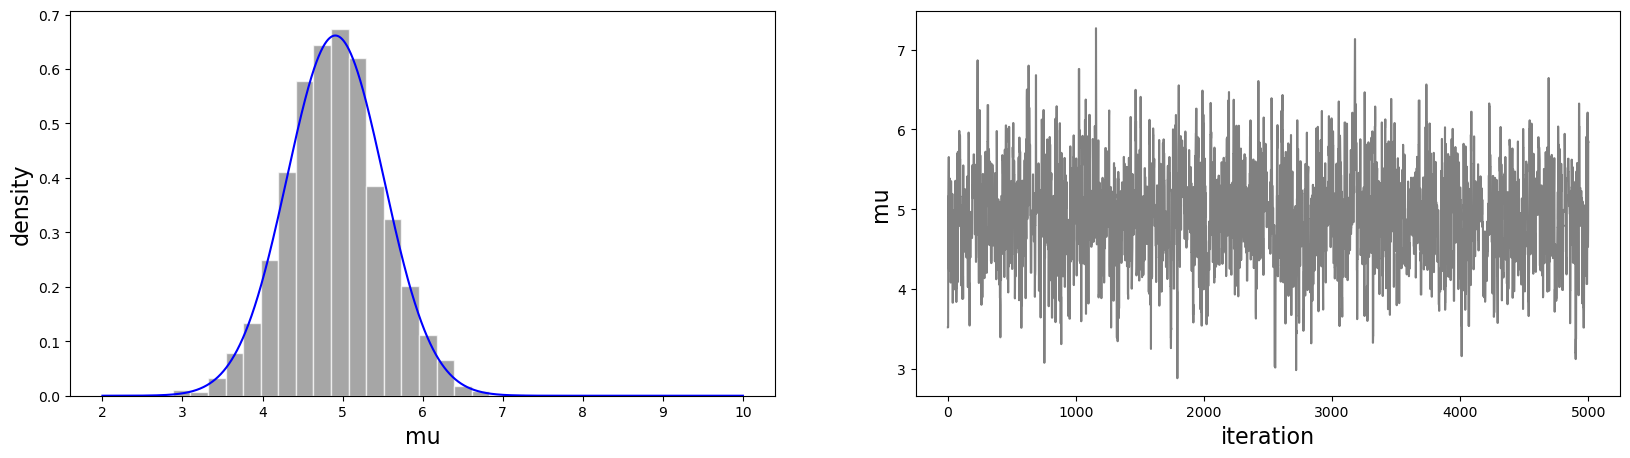

In [9]:
import matplotlib.pyplot as plt

#生成一行两列的画布
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

#density plot：在第一列绘制出采样结果的分布
axs[0].hist(mh_simulation["mu"], 
            edgecolor = "white",
            color="grey",
            alpha = 0.7,
            bins = 20,
            density = True)
axs[0].set_xlabel("mu", fontsize=16)
axs[0].set_ylabel("density", fontsize=16)

# 绘制分布外围线条
x_norm = np.linspace(2,10,10000)                  
y_norm = st.norm.pdf(x_norm, loc=mh_simulation["mu"].mean(), scale=mh_simulation["mu"].std())

axs[0].plot(x_norm, y_norm, color='blue')

#trace plot：在第二列绘制出每一次的采样结果
axs[1].plot(mh_simulation["iteration"], mh_simulation["mu"],
            color="grey",)
axs[1].set_xlabel("iteration", fontsize=16)
axs[1].set_ylabel("mu", fontsize=16)

我们可以使用 arviz 简化这个绘图的过程

(2.0, 10.0)

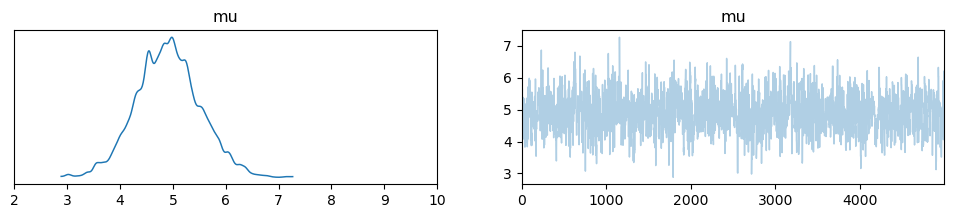

In [14]:
import arviz as az
import matplotlib.pyplot as plt

ax = az.plot_trace({"mu":mh_simulation["mu"]})

ax[0, 0].set_xlim(2, 10)


### 调试(Tuning)Metropolis-Hastings 算法  

在建议分布 $\mu_{n+1} | \mu_{n} \; \sim \; \text{Normal}(\mu_{n}, \sigma)$中，$\sigma$反映了 建议选项的分布宽度，对$\sigma$ 的选择也会影响马尔科夫链的表现  

🧐思考：我们仍然使用MH算法，尝试三种不同的$\sigma$  
* $\sigma = 0.01$  
* $\sigma = 1$  
* $\sigma = 100$  
    
请你判断以下的轨迹图和密度图分别对应上述哪种情况  

![Image Name](https://www.bayesrulesbook.com/bookdown_files/figure-html/ch7-bad-idea-1.png)  


可以结合以下代码进行判断

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import scipy.stats as st
import pandas as pd

def one_mh_iteration(current, sigma = 1):

    """
    def后面为函数值，current为输入值，作为建议分布(正态分布)的均值
    
    接下来的代码和之前一样

    return 则是该函数返回的值，我们将建议值，接受概率，和下一个位置这三个值组成了一个数据框进行返回
    """
    proposal = st.norm(current, sigma).rvs()

    prior = st.norm(loc = 3, scale = 1)
    def likelihood(theta):
        # 假设数据 Y 为 6
        Y = 6
        return st.norm(loc = theta, scale = 0.75).pdf(Y)
        
    proposal_posterior = prior.pdf(proposal) * likelihood(proposal)
    current_posterior = prior.pdf(current) * likelihood(current)
    alpha = min(1,proposal_posterior/current_posterior)
    next_stop = np.random.choice([proposal, current], 1, p=[alpha,1-alpha])
    return pd.DataFrame({"proposal":[proposal],
                         "alpha":[alpha], 
                         "next_stop":[next_stop[0]]})

def mh_tour(N, sigma = 1):

    """
    N为迭代次数，sigma为正态建议分布的标准差

    我们在单次采样函数的基础上叠加了一个循环
    将每次的采样结果存在mu[i]中，
    在每次采样结束后，将采样结果替换为当前位置

    返回值为迭代次数，和每次采样得到的结果
    """
    current = 3
    mu = np.zeros(N)

    for i in range(N):
        sim = one_mh_iteration(current,sigma)
        mu[i] = sim["next_stop"][0]
        current = sim["next_stop"][0]
    
    return pd.DataFrame({"iteration": range(1,N+1),
                         'mu': mu})

In [ ]:
#===========================================================================
#                            请修改 ... 中的值。
#===========================================================================
np.random.seed(84735)

mh_simulation = mh_tour(N=5000, sigma= ...)
az.plot_trace({"mu": mh_simulation["mu"]})

In [ ]:
#===========================================================================
#                            可以自行复制代码多试几次
#===========================================================================
mh_simulation = mh_tour(N=5000, sigma= ...)
az.plot_trace({"mu": mh_simulation["mu"]})

**总结**  

* 当$w = 0.01$时：  

    建议分布的范围很窄，比如$Normal(3, 0.001)$，这会导致下一个建议值和当前值非常接近，则$f(\mu')L(\mu'|y) \approx f(\mu)L(\mu|y)$  
    $$  
    \alpha = \min\left\lbrace 1, \; \frac{f(\mu')L(\mu'|y)}{f(\mu)L(\mu|y)} \right\rbrace \approx \min\left\lbrace 1, \; 1 \right\rbrace \; = 1 .  
    $$  
    那么我们很容易接受下一个采样值，但尽管马尔科夫链一直在转移，但探索的范围太窄了，我们可以看到采样一直在3附近  

* 当$w = 100$时：  

    类似的，我们可以推知此时建议分布的范围太宽了，超出了$\mu$可能的取值  

    下一个建议值和当前值间隔太远，这会导致我们经常拒绝下一个采样值，多次停在当前位置。

**补充介绍：细致平衡 (detail Balance)**  

我们已经感受到，从一个自定义的建议分布$q(x)$中采样，竟然可以得到关于参数的后验分布$p(x)$。  

🤔这非常神奇，这到底是怎么做到的？  

一切的关键在于，MCMC 的性质：细致平衡 (detail Balance)。  
- 正如之前关于心情的例子一样，只要我们每天都记录自己的开心程度。我们就可以得到关于自己心境的分布。 也对应了参数的**后验分布**。  
- 这个概率分布代表了心境的乐观水平，分布的均值越大，代表个体越乐观。  
- 而我们在最开始记录心情之前，并不知道这个后验分布是什么形态的。  
- 我们只是按照**转移矩阵**提供的概率转化心情。换句话说，心情受到影响后如何转化是我们确定的(建议分布)，但我们却不清楚自己的乐观程度(后验分布)。  
- 最后需要注意的是，后验分布也**与最开始的心情无关**。无论最开始是开心还是悲伤，都不影响个体总体上乐观的心态。

![Image Name](https://cdn.kesci.com/upload/image/rk6x7auvhk.png?imageView2/0/w/640/h/640)  


它的数学基础在于，当心情无限演化下去，状态转移的概率达到平衡，也就是所谓的细致平衡：  

假设，状态转移矩阵为 P  

| 心情 | 开心$\theta^{(n-1)}_{1}$ | 冷静$\theta^{(n-1)}_{2}$ | 悲伤$\theta^{(n-1)}_{3}$ | ... |  
| :----: | :----: | :----: | :----: | :----: |  
| 开心$\theta^{(n)}_{1}$ | 0.5 | 0.25 | 0.25 | ... |  
| 冷静$\theta^{(n)}_{2}$ | 0.5 | 0 | 0.5 | ... |  
| 悲伤$\theta^{(n)}_{3}$ | 0.25 | 0.25 | 0.5 | ... |  
| ... | ... | ... | ... | ... |  

假设每天记录 10000个个体的心情，我们可以用 $\pi$ 来描述这个群体的心情分布。  

- 可以想象，第二天这 10000个个体的心情可能发生变化，也就是 $\pi * P$ (矩阵乘法)。  
- 由于这 10000个个体的乐观程度不太可能瞬间变化，所以在总体上，他们的分布不换变化，也就是 $\pi * P = \pi$。  
- 那么就会有 $\pi(i)* P(i,j) = \pi(j)* P(j,i)$。其中 i 代表上面矩阵的行，j代表矩阵的列。  

其中，满足上述公式的 $\pi$ 就是参数的后验分布。  
- 然而，我们一开始并不知道 $P$。  
- 但我们可以通过加入建议分布$q(x)$和拒绝率$\alpha$来替代 $P$。  
- 得到： $\pi(i)* q(i,j) * \alpha(i,j) = \pi(j)* q(j, i) * \alpha(j, i)$  

也就是，我们通过建议分布产生参数*拒绝率的方式来采样模拟了P。  
- 一个不恰当的比喻：状态转移矩阵 P 是你真实的乐观程度，但只有上帝知道你的本来面目 P。  
- 然而，你能认识到自己当下的情绪 Q，并且在漫长人生中，你可以识别那些不属于自己的情绪 $\alpha$ 。  
- 最后，你对自己的认识越来越接近上帝....  


最后，推荐 MCMC 讲解最好的视频(没有之一)：【蒙特卡洛（Monte Carlo, MCMC）方法的原理和应用】 https://www.bilibili.com/video/BV17D4y1o7J2/?share_source=copy_web&vd_source=4b5b4646c3f53f1b80954c381226c913  

如果还是不懂 MCMC 原理，那放弃也行.....  

不了解 MCMC 原理，并不影响对于它的使用。

### 小结

无论是在这些相对简单的单参数模型设置中，还是在更复杂的模型设置中，Metropolis-Hastings 算法都是通过两步之间的迭代，从后验中产生近似样本：  
- 设定建议分布  
- 根据建议分布的参数、未标准化后验计算接受率  

本节课我们只考虑了一种 MCMC 算法，即 Metropolis-Hastings。这种算法虽然功能强大，但也有其局限性。  
- 在以后的章节中，我们的贝叶斯模型将增加大量参数。调整 Metropolis-Hastings 算法以充分探索每个参数会变得很笨重。  
- 然而，即使 Metropolis-Hastings 算法的实用性达到了极限，它仍然是一套更灵活的 MCMC 工具的基础，包括自适应 Metropolis-Hastings、Gibbs 和 Hamiltonian Monte Carlo (HMC) 算法。其中，HMC 是 pymc 默认使用的算法。

## PyMC实战

在上一部分，我们学习了 MCMC 算法的基本原理，并通过 Python 代码实现了一次简单的 Metropolis-Hastings 迭代。\
但随着模型复杂性提升，我们发现手动实现 MCMC 代码可能会变得非常繁琐.

同时在第五课中，我们使用网格法对 Beta-Binomial 模型进行了推断，并初步介绍了 PyMC。\
下面我们会深入讲解如何利用 PyMC，借助 MCMC 方法进行高效的贝叶斯推断。

### 为什么选择PyMC？

在实际操作中，PyMC 封装了许多底层 MCMC 算法，如 Metropolis-Hastings 和 NUTS（No-U-Turn Sampler），使得用户可以将更多精力集中在模型构建和推断结果的分析上。

在贝叶斯中，PyMC 提供了一套丰富的接口，覆盖了贝叶斯建模的各个环节，包括模型定义、设置先验和似然分布、采样、后验预测和诊断。

接下来我们介绍 PyMC 的基本使用流程和核心模块。

1. **模型定义**：PyMC 中所有的模型都是在 `pm.Model()`语句中定义的。用户可以在其中指定模型的参数（即先验分布）和观测数据的分布（即似然函数）。
2. **概率分布（Distributions）**：PyMC 支持多种常见的概率分布，例如 Normal, Beta, Bernoulli, Binomial, Poisson 等，用于定义先验和似然分布。用户可以通过`pm.<Distribution>`的形式来定义参数的先验和似然。
3. **采样（Sampling）**：PyMC 使用多种采样算法进行后验采样,如Metropolis-Hastings和NUTS（No-U-Turn Sampler）。

4. **后验预测**：PyMC 支持从后验分布生成新的观测值，根据`pm.sample_posterior_predictive()`它可以帮助我们验证模型的合理性，即模型生成的数据是否与真实数据一致。

5. **诊断和可视化**：PyMC 提供了与 Arviz 包的集成，用户可以使用 `az.plot_trace()`等函数可视化参数的后验分布和采样轨迹，并使用`az.summary()`查看后验统计量。这些工具有助于诊断采样的收敛性和质量。

使用 PyMC 进行贝叶斯建模通常包括以下步骤（以beta-binomial模型进行演示）：



## A Beta-Binomial example in pymc  

假设我们进行了一项随机点运动任务的实验，每个试验中参与者判断正确的概率用 $\pi$ 表示。

**模型假设**

- 我们假设参与者判断正确的概率 $\pi$ 是从 **Beta 分布**中抽样的：

$$  
\begin{equation}  
\pi \sim \text{Beta}(\alpha, \beta)  
\end{equation}  
$$  

- 在每次试验中，参与者的成功次数 $Y$ 服从一个 **Binomial分布**：

$$  
\begin{equation}  
Y \sim \text{Binomial}(n, \pi)  
\end{equation}  
$$  

其中，$n$是试验的总次数，$Y$是成功次数。

**模型设定**

在这个例子中，我们可以使用Beta-Binomial 模型来表示：

> 先验分布为：$\pi    \sim \text{Beta}(2, 2)$  
> 似然函数为：$Y|\pi  \sim \text{Bin}(10, \pi)$  
> 总试验数为10，成功次数为9 $(Y = 9)$  


接下来，我们将使用 Pymc 来表达和设定 Beta-Binomial 模型

In [1]:
import pymc as pm
import arviz as az

In [2]:
# 定义观测值Y=9
Y = 9

# 创建一个 PyMC 模型名为 bb_model
bb_model = pm.Model()

# 使用with语句将模型与变量联系起来
with bb_model:
    # 定义一个符合beta先验分布的变量pi
    pi = pm.Beta('pi', alpha=2, beta=2)
    # 定义符合binomial分布的变量likelihood，其中总次数为10，成功概率为pi，观测值为Y
    likelihood = pm.Binomial('likelihood', n=10, p=pi, observed=Y)

**代码解释**  

```python  
Y = 9  

bb_model = pm.Model()  

with bb_model:  
    pi = pm.Beta('pi', alpha=2, beta=2)  
    likelihood = pm.Binomial('likelihood', n=10, p=pi, observed=Y)  
```

在pymc中，一个模型的定义通常包含了先验和似然两部分(其复杂性视模型复杂程度而定)：  

1. 设立容器  
    * 在pymc中，你需要创建一个`pm.Model()`来容纳你模型中的变量  

    * 接下来你需要定义模型里的各种参数，即`with bb_model:`，表明接下来你对模型中各参数的设定，都会被添加到该模型中  

    * 或者也可以直接一步写成：`with pm.Model() as bb_model:`  

2. 定义先验  
    * 在这个例子中，我们需要对$\pi$进行定义  

3. 定义似然  
    * 我们通过observed = Y，将收集到的数据传入似然函数中  


### 模型可视化  

可以通过PyMC3自带的可视化工具将模型关系可视化

In [ ]:
pm.model_to_graphviz(bb_model)

### 使用mcmc进行采样  

在以下例子中，将 MCMC 采样方法得到的参数样本赋值为 `trace`。  
- 使用 `sample` 方法进行 MCMC 采样模拟过程。  
- 设置参数 `draws` 来控制 MCMC 采样的次数。  
- `chains` 表示同时运行几条MCMC链。  

我们可以使用 `arviz` 的方法 `plot_trace` 来可视化该结果  
- 左图为参数分布图  
- 右图为 trace 图，代表随着采样的进行(即x轴1-5000次采样)，每个参数值的大小(即y轴为每个采样参数的大小)。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pi]


Output()

Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

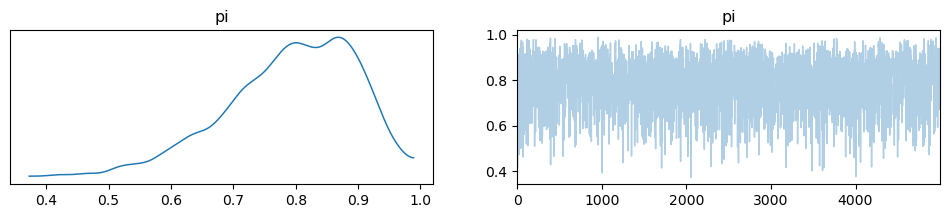

In [7]:
#采样过程仍在该容器中进行
with bb_model:
    trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                      chains=1,                     # 设置MCMC的链数
                      random_seed=84735)            # 设置随机状态，以获得与notebook相同的结果

# 可视化采样结果
az.plot_trace(trace)

### 采样的时间进程  

下图展示了第一条Makov链的前20个采样结果和前200个结果  


array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

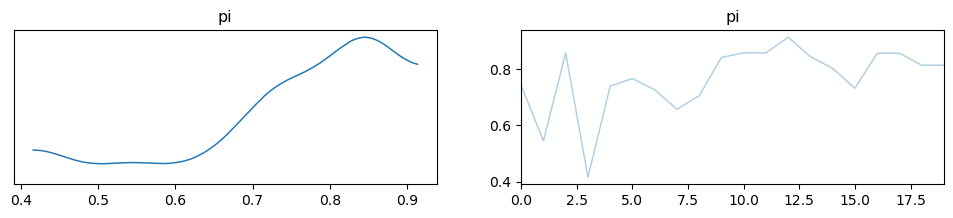

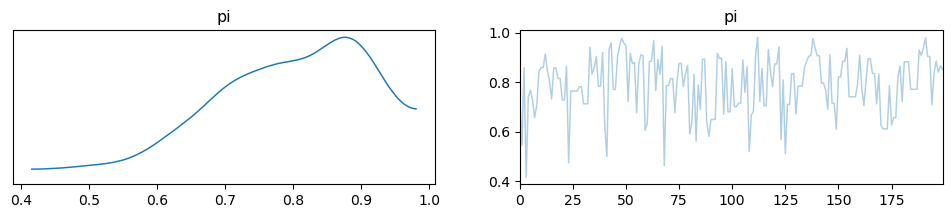

In [8]:
# 选取第一条Makov链的前20个采样结果和前200个结果
# 从trace中提取pi的值，使用sel(chain=0)表示为选择第一条markov链。使用.values[:20]表示选取前20个采样结果
samples_20 = trace.posterior["pi"].sel(chain=0).values[:20]
samples_200 = trace.posterior["pi"].sel(chain=0).values[:200]

# 绘图
# az.plot_trace表示绘制前20个采样结果的轨迹图，其中pi为变量名，samples_20为采样结果
az.plot_trace({"pi": samples_20})
az.plot_trace({"pi": samples_200})

In [10]:
import pandas as pd
post_pi = pd.DataFrame({"pi": trace.posterior["pi"].values.reshape(-1)})
post_pi

,pi
0,0.741947
1,0.544469
2,0.858457
3,0.415141
4,0.739664
...,...
4995,0.730776
4996,0.938275
4997,0.821699
4998,0.821699


### 采样结果可视化  

* 将采样结果(5000次采样)对比真实的后验分布(黑线)Beta(11, 3)  

* 可以看到这个采样结果很好地近似了后验分布

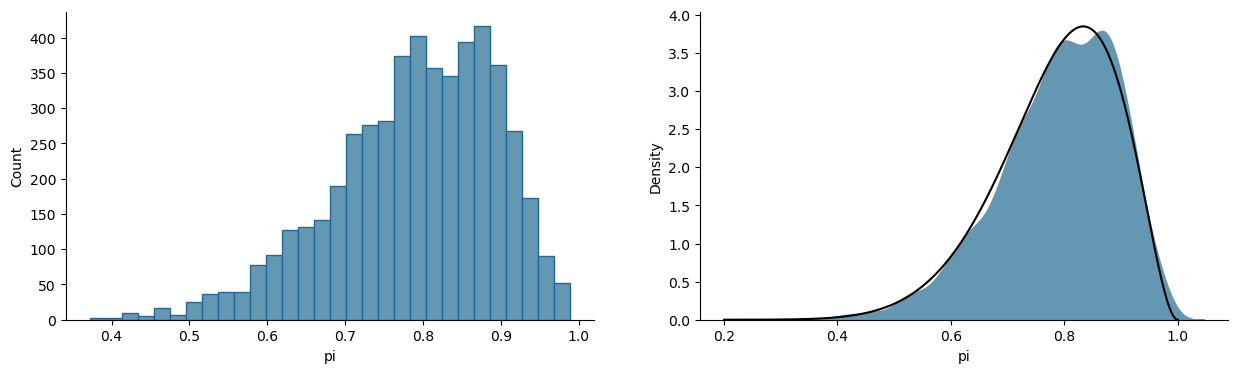

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st 

fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(15, 4))

#绘制采样结果直方图
sns.histplot(data=post_pi, 
             x="pi", 
             bins=30,
             ax=axs1,
             edgecolor='#20699d', 
             color="#6497b1",
             alpha = 1)

#绘制采样结果密度分布图
sns.kdeplot(data=post_pi,
             x="pi",
             color='#6497b1',
             fill=True,
             alpha = 1,
             ax=axs2)

#绘制真实后验分布图
x = np.linspace(0.2, 1, 10000)
# 真实的后验分布 beta（alpha + y, beta + n - y）
y = st.beta.pdf(x, 11, 3)
axs2.plot(x, y, color='black')

sns.despine()

## 练习  
> 📃以**Normal-Normal模型**为例来练习使用pymc进行MCMC模拟    

在lec5中，我们利用基于**Normal-Normal模型**的例子练习了网格近似法来估计参数。

接下来，我们基于 Normal-Normal 再次对平均反应时间和标准差进行推断。不过这次，我们将使用 PyMC 实现 MCMC 采样，而不是网格法.

**模型设定：**  
- 假设 $\mu$ 是参与者在随机点运动任务中的**平均反应时间**（单位：ms）。
- 假设 $\sigma$ 是参与者在随机点运动任务中的**标准差**（单位：ms）。  
  
**先验分布**  
我们对参与者的反应时间有一个初步的假设：
- 先验分布设为正态分布，平均反应时间$\mu$约为 300 ms，标准差 $\sigma$ 为 50 ms。
- 因此， $\mu$ 的先验分布可以表示为
$$
\mu \sim \text{Normal}(300, 50)
$$  

**观测数据**  
- 观测数据 $Y$ 表示参与者在实验中实际的反应时间。
- 假设我们收集了被试完成 5 次实验的反应时间：
$$
Y = [320, 310, 280, 340, 300] ms
$$

- 反应时间 $Y$ 的标准差 $\sigma$ 被认为是已知的，$\sigma$ = 20 ms。

**条件模型** 
- 观测数据 $Y_i$服从一个均值为$\mu$、标准差为 $\sigma$ 的正态分布：

$$
Y_i |\mu \stackrel{ind}{\sim} \text{Normal}(\mu, \sigma^2)
\tag{1}
$$

<div style="padding-bottom: 30px;"></div>


- 结合先验分布，完整的模型表示为：

$$  
\begin{equation}  
\begin{split}  
Y_i|\mu & \stackrel{ind}{\sim} \text{Normal}(\mu, \sigma^2) \\  
\mu & \sim \text{Normal}(\mu_0, \sigma_0^2) . \\  
\end{split}  
\tag{1}  
\end{equation}  
$$  

<div style="padding-bottom: 30px;"></div>

In [41]:
import pymc as pm
import arviz as az

In [42]:
#===========================================================================
#                            请修改 ... 中的值。
#===========================================================================

observed_data = [...]

#1. 设立容器

with pm.Model() as nn_model:
    #2. 定义先验
    mu_prior = pm.Normal('...', mu= ..., sigma= ...)
    #3. 定义似然
    Y_obs = pm.Normal('...', mu=..., sigma= ..., observed=...)

In [43]:
#===========================================================================
#                            请修改 ... 中的值。
#===========================================================================
with nn_model:
    trace = pm.sample(draws= ...,                    # 例如采样次数设为500-5000次
                      chains=1,                     # 链为1条
                      random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_prior]


Output()

Sampling 1 chain for 1_000 tune and 5_000 draw iterations (1_000 + 5_000 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [44]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'mu_prior'}>,
        <Axes: title={'center': 'mu_prior'}>]], dtype=object)

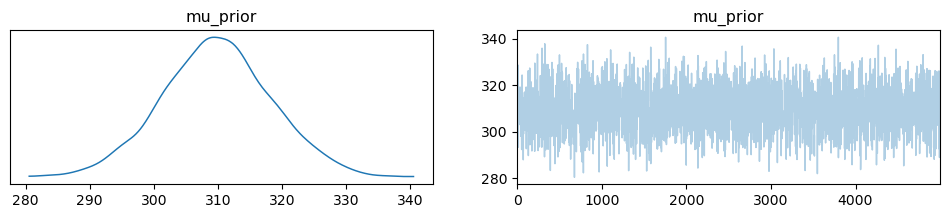

In [45]:
az.plot_trace(trace)

In [46]:
# 从 MCMC 采样结果中提取参数 mu 的后验分布样本
post_mu = pd.DataFrame({"mu": trace.posterior["mu_prior"].values.reshape(-1)})

In [63]:
#===========================================================================
#                            为了和真实的后验分布进行比较，计算真实的后验分布。
#===========================================================================


# 先验分布的均值和标准差
mu_prior = 300  # 先验均值
sigma_prior = 50  # 先验标准差

# 观测数据的标准差 (已知)
sigma_obs = 20

# 计算观测数据的数量和均值
n = len(observed_data)  
y_mean = np.mean(observed_data)  

# 计算后验分布的均值和方差
posterior_mean = (sigma_obs**2 * mu_prior + n * sigma_prior**2 * y_mean) / (n * sigma_prior**2 + sigma_obs**2)
posterior_variance = (sigma_prior**2 * sigma_obs**2) / (n * sigma_prior**2 + sigma_obs**2)
posterior_std = np.sqrt(posterior_variance)

print(f"后验分布的均值: {posterior_mean}")
print(f"后验分布的标准差: {posterior_std}")

后验分布的均值: 309.68992248062017
后验分布的标准差: 8.804509063256237


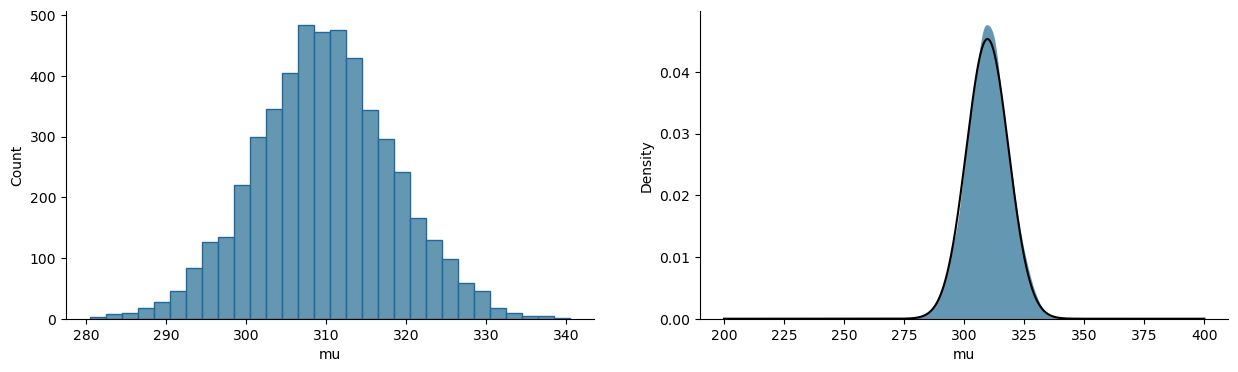

In [64]:
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(15, 4))

sns.histplot(data=post_mu, 
             x="mu", 
             bins=30,
             ax=axs1,
             edgecolor='#20699d', 
             color="#6497b1",
             alpha = 1)

sns.kdeplot(data=post_mu,
             x="mu",
             color='#6497b1',
             fill=True,
             alpha = 1,
             ax=axs2)



# 计算真实的后验分布
x = np.linspace(200, 400, 10000)
y = st.norm.pdf(x, posterior_mean, posterior_std)
axs2.plot(x, y, color='black')

sns.despine()


### 总结  

在本节课中，我们深入探讨了 Metropolis-Hastings 算法 及其实际应用。通过 Normal-Normal 模型 的例子，我们演示了如何使用 MCMC 来近似后验分布。MCMC 是一种非常强大的工具，尤其在解析解无法直接求得时，提供了一种灵活且有效的计算方法。

随着模型的复杂性增加，**后验分布可能变得难以解析，甚至无法获得。** 在这种情况下，近似方法是必要的。

我们学习了两种用于逼近后验分布的技术：
1. **网格近似法：** 通过离散化参数空间，计算每个点的后验分布，再通过这些点近似整个后验。
2. **马尔科夫链蒙特卡罗（MCMC）：** 通过随机采样，生成符合后验分布的样本，逼近目标分布。

